# Motivation
This notebook analyses the spreadsheet containing information on the reversals. This spreadsheet collects different features on the trades in an attempt of creating a binary classifier, this classifier will learn from the data collected and will predict the value of the `outcome` variable, which can be success of failre

# Data
The data has been collected in an spreadsheet containing trades both simulated and real. And the different trades have been classified into three types: continuation, counter and ranging. The independent variables gathered for each trade type are:
## Continuation trades
* id	id used in the screenshot folder to identify this record
* start	start of this trade
* timeframe	in the format 2D,D,H12,H8
* entry	price
* outcome	S=success;F=failure;B=breakeven
* ext_outcome. S=success;F=failure;B=breakeven
* RSI bounces. number of RSI bounces ocurring in the trend before entry
* No of candles. How many candles before occurred the bounce, from the entry of trade to the first bounce (without counting the entry candle)
* entry on RSI. Was the entry candle on RSI?
* length of trend. lenght of the preceding trend in number of candles. The valley before the continuation is not included in the count
* previous swings. Number of swings from the entry and counting the rebound before the entry (see screenshot below)
* space interswings. Comma separated numbers representing the number of candles between swings from the most recent to the oldest
* length in pips. From the beginning of the trade to the entry price in number of pips
strong trend	TRUE of the preceding trend was strong
* trend angle. Measured with Oanda after hitting the auto scale button+lock scalde button and the end of the trend line is the IC+1 when it touches the entry price
* bounce length. Length in number of candles for each of the bounces (in the order from the most recent to the oldest)
* bounce pips. Length from the horizontal line defined by IC until the highest point of the bounce (considering wicks also)
* inn_bounce. Number of candles of the inner bounce (see screenshots below)
indecission	Number of candles the price stays in S/R, without considering the bounce and only considering the candles pre/post bounce
* retraced.	Only relevant for outcome=F, how many pips from the S/L the trade reversed?. If n.a., then it means that the trade did not reversed last time that the price was below/above this level assuming that a possible counter could happen
* entry_aligned. Is the entry aligned with previous bounces on the same trend. TRUE or 1 if it is, FALSE or 0 if it is not
* trend_bounces. Discrete quantitative variable representing the number of bounces at the trend

## Dependencies

In [1044]:
import pandas as pd
import numpy as np
import pdb
import re
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix,precision_score
from sklearn.model_selection import train_test_split

%matplotlib inline

# Continuation trades

First, let's create a function to read-in a .csv file containing the data andstore it in a dataframe:

In [1045]:
def read_tradedata(tradefile,sep,na_values):
    '''
    Parameters
    ----------
    tradefile : str, required
                Path to file containing the trade data
    sep : str, optionsl
          Field separator used in the file. i.e. ',' (comma separated values), '\t' (tab-separated values)
    na_values : list, optional
                Additional list of strings to recognize as NA/NaN. i.e. ['n.a.']
    
    Returns
    -------
    A Pandas dataframe
    '''
    DF=pd.read_csv(tradefile,sep=sep,na_values=na_values)
    
    return DF

contDF=read_tradedata('/Users/ernesto/Downloads/Screenshot analysis - continuations.tsv',sep="\t",na_values=["n.a.","n.a"])

contDF.shape

(383, 27)

And some information about contDF:

In [1046]:
contDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 27 columns):
id                         383 non-null object
start                      383 non-null object
type                       383 non-null object
timeframe                  383 non-null object
entry                      383 non-null float64
outcome                    383 non-null object
RSI bounces                383 non-null int64
bounce length              298 non-null object
bounce (pips)              383 non-null int64
inn_bounce                 383 non-null int64
indecission                383 non-null int64
entry on RSI               383 non-null bool
length of trend (-1)       383 non-null int64
length in pips (-1)        383 non-null int64
strong trend               294 non-null object
last time                  383 non-null object
entry_aligned              383 non-null int64
retraced                   96 non-null float64
Candle +1 against trade    383 non-null object
trend_boun

* Conversion to right types<br>
Let's convert now the `start` and `last time` variables to DateTime

In [1047]:
contDF['start']= pd.to_datetime(contDF['start'])
contDF['last time']= pd.to_datetime(contDF['last time'])

## Cleaning the n.a. values
The following predictors have n.a. values and the strategy I will follow will depend on each case:

* No of candles (will replace the n.a. by 0)

In [1048]:
if "No of candles" in contDF: contDF["No of candles"].fillna(0, inplace=True)

* Bounce length (will replace the n.a. by 0)

In [1049]:
contDF["bounce length"].fillna(0, inplace=True)

* Length of trend (-1) (will replace the n.a. by 0)

In [1050]:
contDF["length of trend (-1)"].fillna(0, inplace=True)

* Length in pips (-1) (will replace the n.a. by 0)

In [1051]:
contDF["length in pips (-1)"].fillna(0, inplace=True)

## Transforming

In [1052]:
transl_dict={ 
        'S':1,
        'F':0, 
        True:1, 
        False:0
    }
def digit_binary(x,transl_dict,name):
    '''
    This function will replace the values in categorical
    binary variables by 1 and 0
    
    Parameters
    ----------
    transl_dict: dict
                 Keys will be the old categorical names and Values
                 will be 1 and 0. For example:
                 transl_dict={ 
                            'S':1,
                            'F':0, 
                            True:1, 
                            False:0
                            }
    name: str
          Name of the column to modify
        
    Returns
    -------
    The new label for the categorical variable
    '''
    
    return transl_dict[x[name]]

if "ext_outcome" in contDF: contDF['ext_outcome']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='ext_outcome')
contDF['outcome']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='outcome')
contDF['entry on RSI']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='entry on RSI')
if "strong_trend" in contDF: contDF['strong trend']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='strong trend')

## Selecting the desired timeframe

In [1053]:
contDF=contDF[contDF.timeframe == 'H6']
print(contDF.columns)

Index(['id', 'start', 'type', 'timeframe', 'entry', 'outcome', 'RSI bounces',
       'bounce length', 'bounce (pips)', 'inn_bounce', 'indecission',
       'entry on RSI', 'length of trend (-1)', 'length in pips (-1)',
       'strong trend', 'last time', 'entry_aligned', 'retraced',
       'Candle +1 against trade', 'trend_bounces', 'is_sr_doubtful',
       'length of trend', 'No of candles', 'previous swings',
       'space interswings', 'trend angle', 'stretches'],
      dtype='object')


## Initial exploration of the data

First things first, let's examine if we have a significant number of records per category of the dependent variable (outcome in this case), since it is really very important to have enough records to establish solid conclusions

In [1054]:
outcome_ix=5
outcome_lab="outcome"
contDF.iloc[:,outcome_ix].value_counts()

1    36
0    21
Name: outcome, dtype: int64

###  RSI bounces
Let's examine if there is a correlation between the number of bounces and the outcome of the trade

As an initial exploration I will create a boxplot displaying the data

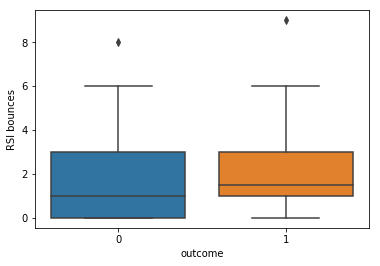

In [1055]:
ax = sns.boxplot(x=outcome_lab, y="RSI bounces", data=contDF)

* Mean for each category

In [1056]:
contDF.groupby(outcome_lab).agg({'RSI bounces': 'mean'})

,RSI bounces
outcome,
0,1.904762
1,2.000000


* Median for each category

In [1057]:
medianBounce=contDF.groupby(outcome_lab).agg({'RSI bounces': 'median'})
print(medianBounce)

         RSI bounces
outcome             
0                1.0
1                1.5


* Distribution of the number of bounces<br>
For this particular task I will create a count plot in order to plot the RSI bounces for both the successful and the failed trades

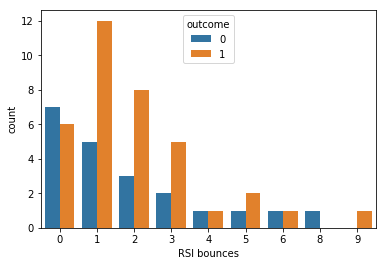

In [1058]:
ax = sns.countplot(x="RSI bounces",hue=outcome_lab, data=contDF)

Now, let's calculate the normalized number of bounces, as the 2 categories of the outcome variables are imbalanced

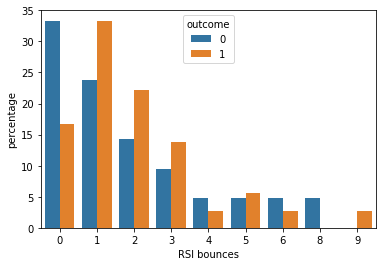

In [1059]:
contDF_counts = (contDF.groupby([outcome_lab])['RSI bounces']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('RSI bounces'))

p = sns.barplot(x="RSI bounces", y="percentage", hue=outcome_lab, data=contDF_counts)

* Histogram

In [1060]:
import matplotlib.pyplot as plt

succ=contDF.loc[contDF[outcome_lab]==1]['RSI bounces']
fail=contDF.loc[contDF[outcome_lab]==0]['RSI bounces']

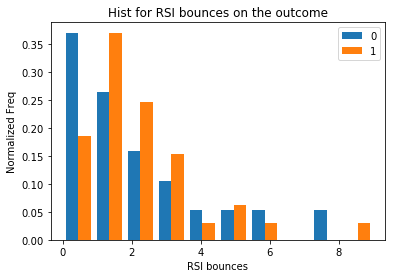

In [1061]:
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('RSI bounces')
plt.ylabel('Normalized Freq')
plt.title('Hist for RSI bounces on the outcome')

* Conclusion<br>
The ideal situation for having a S trade is to have either 1 or 2 bounces

### No of candles
This variable represents the number of candles since the beginning of the trade until the first RSI bounce. I am going compare the distribution of this variable depending on the `outcome` variable.<br>

As an initial exploration I will create a boxplot displaying the data:

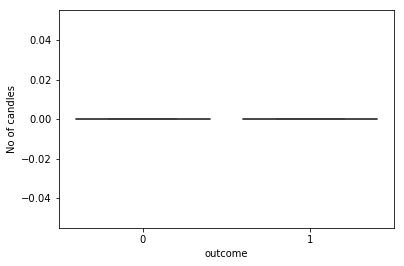

In [1062]:
if "No of candles" in contDF: ax = sns.boxplot(x=outcome_lab, y="No of candles", data=contDF)

* Mean for each category

In [1063]:
if "No of candles" in contDF: contDF.groupby(outcome_lab).agg({'No of candles': 'mean'})

* Median for each category

In [1064]:
if "No of candles" in contDF: contDF.groupby(outcome_lab).agg({'No of candles': 'median'})

Let's analyze the distribution with a histogram

In [1065]:
if "No of candles" in contDF: succ=contDF.loc[contDF[outcome_lab]==1]['No of candles']
if "No of candles" in contDF: fail=contDF.loc[contDF[outcome_lab]==0]['No of candles']

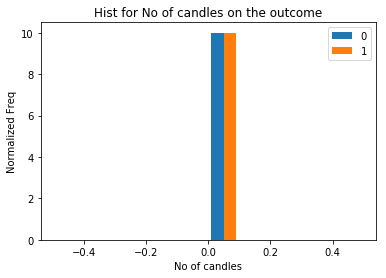

In [1066]:
if "No of candles" in contDF: plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

if "No of candles" in contDF: plt.legend()
if "No of candles" in contDF: plt.xlabel('No of candles')
if "No of candles" in contDF: plt.ylabel('Normalized Freq')
if "No of candles" in contDF: plt.title('Hist for No of candles on the outcome')

This distribution is right skewed, let's cap the X axis values:

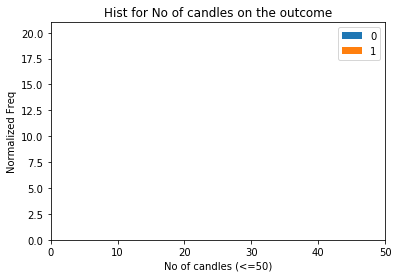

In [1067]:
if "No of candles" in contDF: plt.xlim(0,50)
if "No of candles" in contDF: plt.hist([fail,succ], bins = 20, normed=True, label=['0','1'])

if "No of candles" in contDF: plt.legend()
if "No of candles" in contDF: plt.xlabel('No of candles (<=50)')
if "No of candles" in contDF: plt.ylabel('Normalized Freq')
if "No of candles" in contDF: plt.title('Hist for No of candles on the outcome')

### entry on RSI
This boolean variable will be True if the entry of the trade is in oversold/overbought RSI
Firs, let's see the counts for each category of the variable

In [1068]:
contDF['entry on RSI'].value_counts()

0    39
1    18
Name: entry on RSI, dtype: int64

Let's compare the proportions for this variable between the 2 categories of the `outcome` variable

In [1069]:
div_class=pd.crosstab(contDF.iloc[:,outcome_ix], contDF['entry on RSI'],margins=True)
print(div_class)

entry on RSI   0   1  All
outcome                  
0             18   3   21
1             21  15   36
All           39  18   57


It's is easier to visualize the relationship if we calculate the percentages:

In [1070]:
prop=(div_class/div_class.loc["All"])*100
print(prop)

entry on RSI           0           1         All
outcome                                         
0              46.153846   16.666667   36.842105
1              53.846154   83.333333   63.157895
All           100.000000  100.000000  100.000000


### length of trend (-1)
This quantitative discrete variable measures the length of the trade measured in term of the number of candles. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

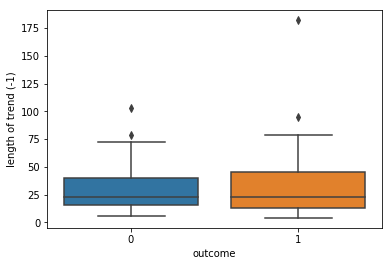

In [1071]:
ax = sns.boxplot(x=outcome_lab, y="length of trend (-1)", data=contDF)

Let's analyze the distribution with a histogram

In [1072]:
succ=contDF.loc[contDF[outcome_lab]==1]['length of trend (-1)']
fail=contDF.loc[contDF[outcome_lab]==0]['length of trend (-1)']

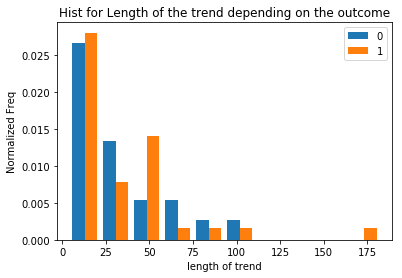

In [1073]:
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('length of trend')
plt.ylabel('Normalized Freq')
plt.title('Hist for Length of the trend depending on the outcome')

This distribution is right skewed, let's cap the X axis values:

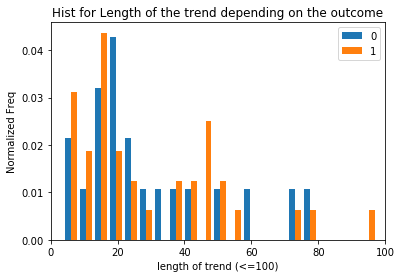

In [1074]:
plt.xlim(0,100)
plt.hist([fail,succ], bins = 40, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('length of trend (<=100)')
plt.ylabel('Normalized Freq')
plt.title('Hist for Length of the trend depending on the outcome')

* Mean for each category

In [1075]:
contDF.groupby(outcome_lab).agg({'length of trend (-1)': 'mean'})

,length of trend (-1)
outcome,
0,33.142857
1,34.277778


* Median for each category

In [1076]:
contDF.groupby(outcome_lab).agg({'length of trend (-1)': 'median'})

,length of trend (-1)
outcome,
0,23.0
1,22.5


### Pips_ratio
This variable contains the ratio between 'length of trend (-1)'/'length in pips'

In [1077]:
contDF['pips_ratio']=contDF['length in pips (-1)'].astype(int)/contDF['length of trend (-1)'].astype(int)

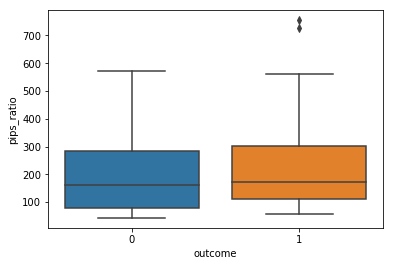

In [1078]:
ax = sns.boxplot(x=outcome_lab, y="pips_ratio", data=contDF)

* Mean for each category

In [1079]:
contDF.groupby(outcome_lab).agg({'pips_ratio': 'mean'})

,pips_ratio
outcome,
0,206.900912
1,226.111796


* Median for each category

In [1080]:
contDF.groupby(outcome_lab).agg({'pips_ratio': 'median'})

,pips_ratio
outcome,
0,160.916667
1,171.986765


Let's analyze the distribution with a histogram

In [1081]:
succ=contDF.loc[contDF[outcome_lab]==1]['pips_ratio']
fail=contDF.loc[contDF[outcome_lab]==0]['pips_ratio']

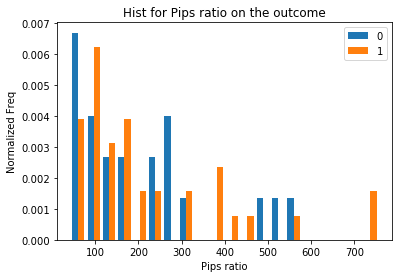

In [1082]:
plt.hist([fail,succ], bins = 20, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Pips ratio')
plt.ylabel('Normalized Freq')
plt.title('Hist for Pips ratio on the outcome')

### inn_bounce
Integer variable representing the number of candles of the inner bounce. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

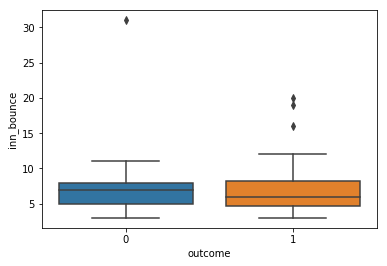

In [1127]:
ax = sns.boxplot(x=outcome_lab, y="inn_bounce", data=contDF)

* Mean for each category

In [1128]:
contDF.groupby(outcome_lab).agg({'inn_bounce': 'mean'})

,inn_bounce
outcome,
0,8.047619
1,7.166667


* Median for each category

In [1129]:
contDF.groupby(outcome_lab).agg({'inn_bounce': 'median'})

,inn_bounce
outcome,
0,7
1,6


* Histogram

In [1130]:
succ=contDF.loc[contDF[outcome_lab]==1]['inn_bounce']
fail=contDF.loc[contDF[outcome_lab]==0]['inn_bounce']

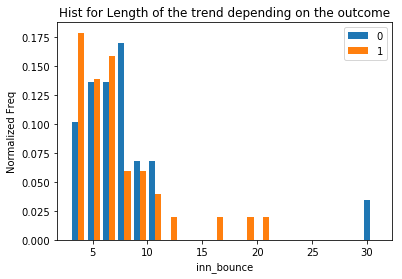

In [1131]:
plt.hist([fail,succ], bins = 20, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('inn_bounce')
plt.ylabel('Normalized Freq')
plt.title('Hist for Length of the trend depending on the outcome')

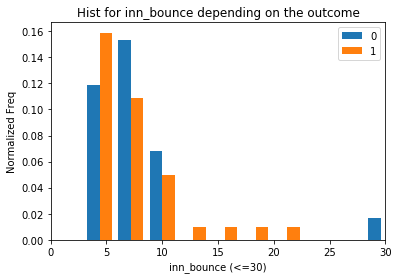

In [1135]:
plt.xlim(0,30)
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('inn_bounce (<=30)')
plt.ylabel('Normalized Freq')
plt.title('Hist for inn_bounce depending on the outcome')

### bounce length
This variable is a comma separated list of integers representing how wide (in number of candles) each of the RSI bounces is. This variable requires a little bit of preprocessing, and I will write a function that calculates the total length (in number of candles) by adding the length of each of the bounces

In [1089]:
def sum_lengths(x):
    '''
    Function to calculate the sum (in number of candles)
    of all the RSI bounces
    
    Parameters
    ----------
    x = string with a comma separated list of numbers
        i.e. 1,4,2,3
        
    Returns
    -------
    An integer representing the total bounce length
    '''
    
    return sum([int(i) for i in x.split(",")])
    

And I will apply the `sum_lengths` function and put the results in a new column named `sum_bounces`

In [1090]:
contDF['sum_bounces']=contDF['bounce length'].astype(str).apply(sum_lengths)

Now, I will plot the distribution of this new variable on each `outcome`category:

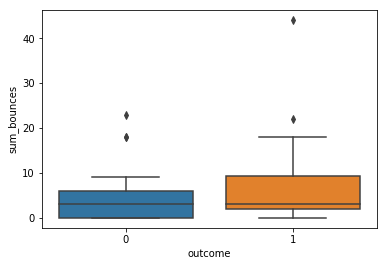

In [1091]:
ax = sns.boxplot(x=outcome_lab, y="sum_bounces", data=contDF)

* Mean for each category

In [1092]:
contDF.groupby(outcome_lab).agg({'sum_bounces': 'mean'})

,sum_bounces
outcome,
0,5.095238
1,6.444444


* Median for each category

In [1093]:
contDF.groupby(outcome_lab).agg({'sum_bounces': 'median'})

,sum_bounces
outcome,
0,3
1,3


* Histogram

In [1094]:
succ=contDF.loc[contDF[outcome_lab]==1]['sum_bounces']
fail=contDF.loc[contDF[outcome_lab]==0]['sum_bounces']

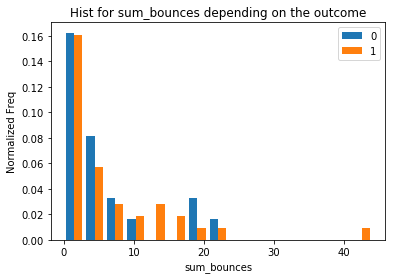

In [1095]:
plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('sum_bounces')
plt.ylabel('Normalized Freq')
plt.title('Hist for sum_bounces depending on the outcome')

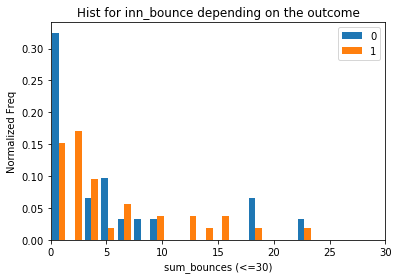

In [1096]:
plt.xlim(0,30)
plt.hist([fail,succ], bins = 30, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('sum_bounces (<=30)')
plt.ylabel('Normalized Freq')
plt.title('Hist for inn_bounce depending on the outcome')

### bounce (pips)
This quantitative variable represents the length from the horizontal line defined by IC until the highest point of the bounce (considering wicks also).  Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

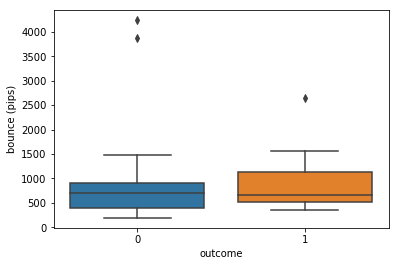

In [1137]:
ax = sns.boxplot(x=outcome_lab, y="bounce (pips)", data=contDF)

* Mean for each category

In [1138]:
contDF.groupby(outcome_lab).agg({'bounce (pips)': 'mean'})

,bounce (pips)
outcome,
0,973.523810
1,839.583333


* Median for each category

In [1139]:
contDF.groupby(outcome_lab).agg({'bounce (pips)': 'median'})

,bounce (pips)
outcome,
0,704
1,653


* Histogram

In [1140]:
succ=contDF.loc[contDF[outcome_lab]==1]['bounce (pips)']
fail=contDF.loc[contDF[outcome_lab]==0]['bounce (pips)']

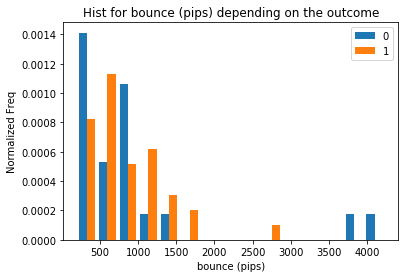

In [1141]:
plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('bounce (pips)')
plt.ylabel('Normalized Freq')
plt.title('Hist for bounce (pips) depending on the outcome')

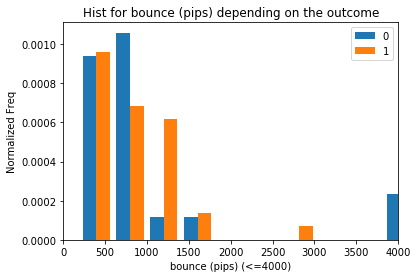

In [1142]:
plt.xlim(0,4000)
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('bounce (pips) (<=4000)')
plt.ylabel('Normalized Freq')
plt.title('Hist for bounce (pips) depending on the outcome')

### entry_aligned
Is the entry aligned with previous bounces on the same trend. TRUE or 1 if it is, FALSE or 0 if it is not

Let's compare the proportions for this variable between the 2 categories of the `outcome` variable

In [1103]:
div_class=pd.crosstab(contDF.iloc[:,outcome_ix], contDF['entry_aligned'],margins=True)
print(div_class)

entry_aligned   0   1  All
outcome                   
0              13   8   21
1               6  30   36
All            19  38   57


It's is easier to visualize the relationship if we calculate the percentages:

In [1104]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

entry_aligned           0           1         All
outcome                                          
0               68.421053   21.052632   36.842105
1               31.578947   78.947368   63.157895
All            100.000000  100.000000  100.000000


* Conclusion <br>
There is a clear relationship between succesful trades and `entry_aligned=1`

### Trend bounces
Discrete variable representing the number of bounces at the trend. This variable only makes sense when entry_aligned=1

In [1105]:
contDF_entryaligned=contDF[contDF.entry_aligned == 1]

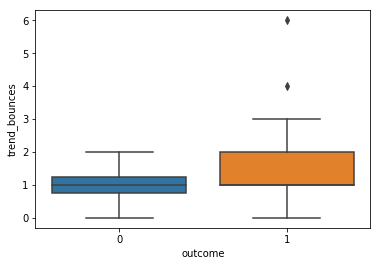

In [1106]:
ax = sns.boxplot(x=outcome_lab, y="trend_bounces", data=contDF_entryaligned)

* Mean for each category

In [1107]:
contDF_entryaligned.groupby(outcome_lab).agg({'trend_bounces': 'mean'})

,trend_bounces
outcome,
0,1.000000
1,1.466667


* Median for each category

In [1108]:
medianBounce=contDF_entryaligned.groupby(outcome_lab).agg({'trend_bounces': 'median'})
print(medianBounce)

         trend_bounces
outcome               
0                  1.0
1                  1.0


* Distribution of the number of bounces<br>
For this particular task I will create a count plot in order to plot the RSI bounces for both the successful and the failed trades

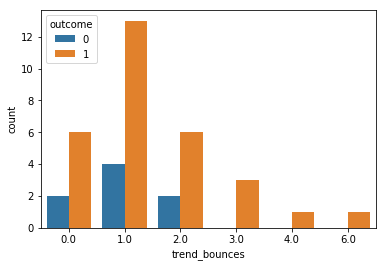

In [1109]:
ax = sns.countplot(x="trend_bounces",hue=outcome_lab, data=contDF_entryaligned)

Now, let's calculate the normalized number of bounces, as the 2 categories of the outcome variables are imbalanced

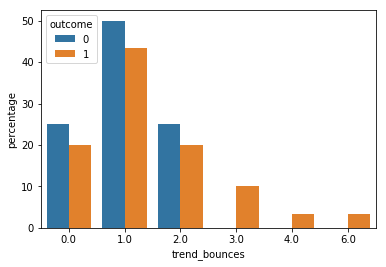

In [1110]:
contDF_counts = (contDF_entryaligned.groupby([outcome_lab])['trend_bounces']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('trend_bounces'))

p = sns.barplot(x="trend_bounces", y="percentage", hue=outcome_lab, data=contDF_counts)

* Histogram

In [1111]:
import matplotlib.pyplot as plt

succ=contDF_entryaligned.loc[contDF_entryaligned[outcome_lab]==1]['trend_bounces']
fail=contDF_entryaligned.loc[contDF_entryaligned[outcome_lab]==0]['trend_bounces']

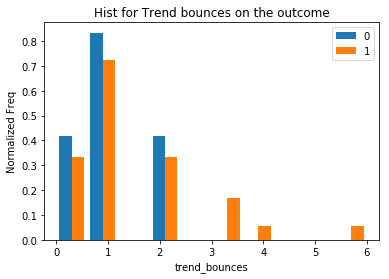

In [1112]:
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('trend_bounces')
plt.ylabel('Normalized Freq')
plt.title('Hist for Trend bounces on the outcome')

### Indecission
Number of candles the price stays in S/R

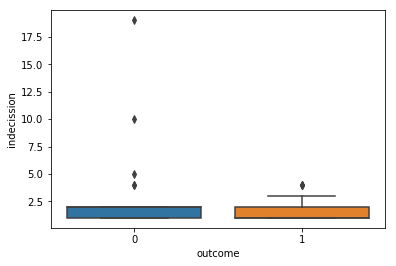

In [1113]:
ax = sns.boxplot(x=outcome_lab, y="indecission", data=contDF)

* Mean for each category

In [1114]:
contDF.groupby(outcome_lab).agg({'indecission': 'mean'})

,indecission
outcome,
0,3.095238
1,1.527778


* Median for each category

In [1115]:
medianBounce=contDF.groupby(outcome_lab).agg({'indecission': 'median'})
print(medianBounce)

         indecission
outcome             
0                  2
1                  1


* Distribution of the number of bounces<br>
For this particular task I will create a count plot in order to plot the RSI bounces for both the successful and the failed trades

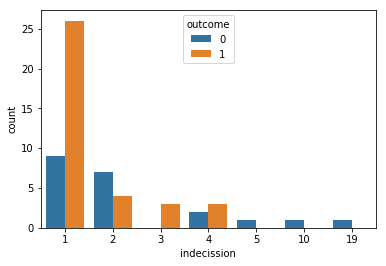

In [1116]:
ax = sns.countplot(x="indecission",hue=outcome_lab, data=contDF)

Now, let's calculate the normalized number of bounces, as the 2 categories of the outcome variables are imbalanced

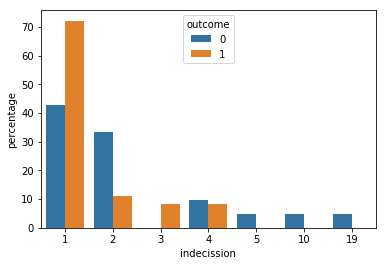

In [1117]:
contDF_counts = (contDF.groupby([outcome_lab])['indecission']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('indecission'))

p = sns.barplot(x="indecission", y="percentage", hue=outcome_lab, data=contDF_counts)

* Histogram

In [1118]:
import matplotlib.pyplot as plt

succ=contDF.loc[contDF[outcome_lab]==1]['indecission']
fail=contDF.loc[contDF[outcome_lab]==0]['indecission']

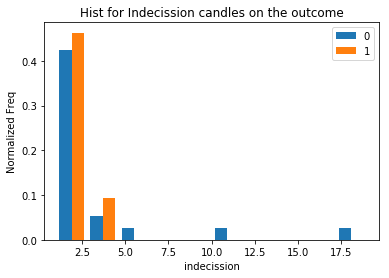

In [1119]:
plt.hist([fail,succ], bins = 10, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('indecission')
plt.ylabel('Normalized Freq')
plt.title('Hist for Indecission candles on the outcome')

### Inn_bounce/Indecisison ratio
Float variable representing the ratio between the internal bounce divided by the indecission ratio

In [1120]:
contDF['bounce_ratio']=contDF['inn_bounce']/contDF['indecission']

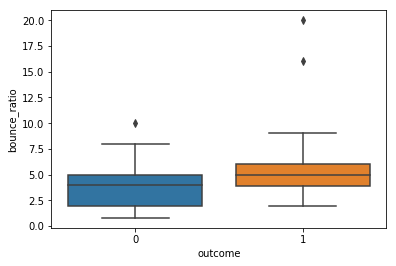

In [1121]:
ax = sns.boxplot(x=outcome_lab, y="bounce_ratio", data=contDF)

* Mean for each category

In [1122]:
contDF.groupby(outcome_lab).agg({'bounce_ratio': 'mean'})

,bounce_ratio
outcome,
0,4.189599
1,5.449074


* Median for each category

In [1123]:
contDF.groupby(outcome_lab).agg({'bounce_ratio': 'median'})

,bounce_ratio
outcome,
0,4.0
1,5.0


Let's analyze the distribution with a histogram

In [1124]:
succ=contDF.loc[contDF[outcome_lab]==1]['bounce_ratio']
fail=contDF.loc[contDF[outcome_lab]==0]['bounce_ratio']

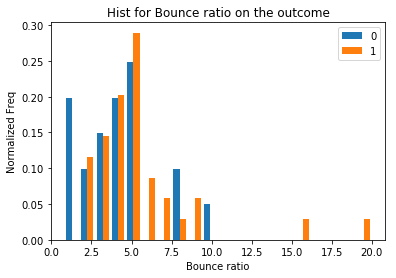

In [1125]:
plt.hist([fail,succ], bins = 20, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Bounce ratio')
plt.ylabel('Normalized Freq')
plt.title('Hist for Bounce ratio on the outcome')

## Calculating points
This section will calculate a total score for each trade that will be used to predict the outcome.<br>

### Splitting the data into training and test sets
Let's split the data into training and test sets. We are going to use a test set size of 0.33

In [777]:
train, test = train_test_split(contDF,
                               test_size=0.33
                              )

First, let's create a function to calculate the points

In [778]:
def calculate_points(row,attribs):
    '''
    Function to calculate the points for a particular trade
    
    Parameters
    ----------
    row : dataframe row
    attribs : list of dicts
              The dict has the following format:
              {'attr' : 'RSI bounces',
               'cutoff' : [(0,6), (7,10), (11,100000)],
               'points' : [2,-2,-3]}
               
    Returns
    -------
    Returns a score for this trade
    
    '''
    score=0
    for a in attribs:
        value=row[a['attr']]
        cutoffs=a['cutoffs']
        points=a['points']
        if cutoffs =='bool':
            if a['rel'] == 'is_true':
                if value == True or value == 1:
                    score+=points
                if value == False  or value == 0:
                    score+=-1*points
        else:
            if len(cutoffs)!= len(points):
                raise Exception("Length of cutoffs is different to length of points")
            for i, j in zip(cutoffs, points):
                if value>=i[0] and value<=i[1]:
                    score+=j
                
    return score

Now, let's apply the calculate_points on each row for the training and the test set

In [792]:
train['score']=train.apply(calculate_points, axis=1, attribs=attbs)
test['score']=test.apply(calculate_points, axis=1, attribs=attbs)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


                       id               start   type timeframe      entry  \
144  GBP_AUD 20APR2009H12 2009-04-20 10:00:00   long       H12    2.05830   
64   USD_CHF 01APR2018H12 2018-01-04 22:00:00   long       H12    0.95460   
173   NZD_JPY 07082008H12 2008-07-08 22:00:00  short       H12   78.06000   
50   GBP_AUD 25APR2017H12 2017-04-25 10:00:00   long       H12    1.70084   
122  EUR_USD 12APR2011H12 2011-12-04 10:00:00   long       H12    1.44708   
187  NZD_JPY 05NOV2017H12 2017-05-11 22:00:00  short       H12   78.72200   
23   AUD_USD 19OCT2011H12 2011-10-19 10:00:00   long       H12    1.03285   
148  GBP_AUD 20MAY2013H12 2013-05-20 22:00:00   long       H12    1.55768   
149  GBP_AUD 02JUN2016H12 2016-02-06 10:00:00   long       H12    2.00244   
137  GBP_USD 26DEC2012H12 2012-12-26 22:00:00   long       H12    1.61725   
72   GBP_USD 10JUN2013H12 2013-10-06 22:00:00   long       H12    1.55903   
39   EUR_USD 06JUL2010H12 2010-06-07 10:00:00   long       H12    1.26109   

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Calculating cutoff score
* Mean

In [781]:
train.groupby(outcome_lab).agg({'score': 'mean'})

,score
outcome,
0,0.596154
1,5.592593


* Median

In [782]:
train.groupby(outcome_lab).agg({'score': 'median'})

,score
outcome,
0,0
1,6


* Histogram

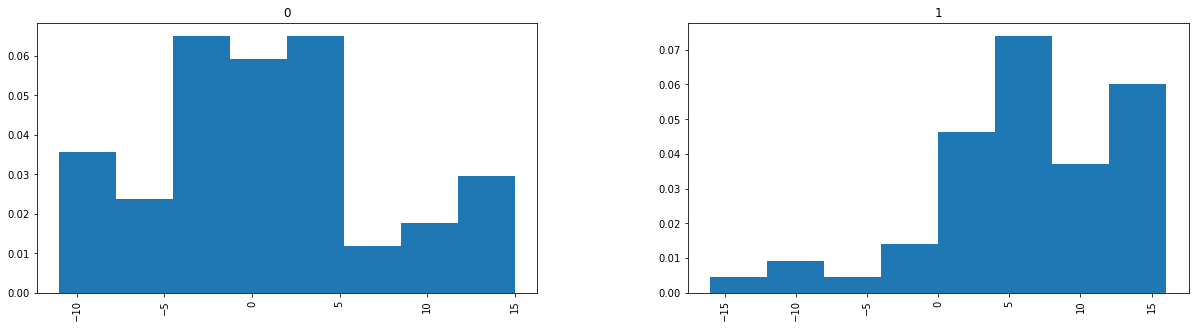

In [783]:
axList=train['score'].hist(by=train[outcome_lab],figsize=(20,5),bins=8,normed=True)

In [784]:
succ=train.loc[contDF[outcome_lab]==1]['score']
fail=train.loc[contDF[outcome_lab]==0]['score']

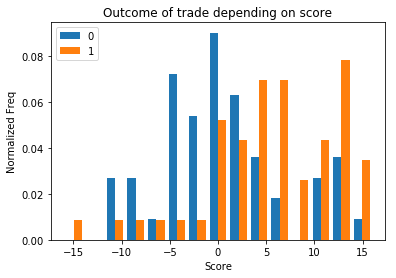

In [785]:
plt.hist([fail,succ], bins = 15, normed=True, label=['0','1'])

plt.legend()
plt.xlabel('Score')
plt.ylabel('Normalized Freq')
plt.title('Outcome of trade depending on score')

### Making predictions and performance evaluation
We will use different cutoffs and make predictions using these using the test set

Let's create a new dataframe only with the columns we are interested in:

In [786]:
scoreDF=test.iloc[:,[outcome_ix,29]]

In [787]:
def predictOutcome(row, cutoff):
    pred=None
    if row['score'] >cutoff:
        pred=1
    else:
        pred=0
    return pred

In [788]:
scoreDF['predict']=scoreDF.apply(predictOutcome,axis=1,cutoff=4)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


* Performance evaluation

In [789]:
(tn, fp, fn, tp)=confusion_matrix(scoreDF['ext_outcome'], scoreDF['predict']).ravel()
print("TP:"+str(tp))
print("TN:"+str(tn))
print("FN:"+str(fn))
print("FP:"+str(fp))

TP:18
TN:18
FN:10
FP:7


    * Precision

In [790]:
print(tp/(tp+fp))

0.72


* Recall

In [791]:
print(tp/(tp+fn))

0.642857142857


### Using a Binary classifier
First, let's prepare the data by separating the data into labels (dependent variable, which is the variable we try to predict) and features (the independent variables that are going to be used for the model)

In [296]:
labels=contDF['ext_outcome']
features=contDF.drop(["ext_outcome","outcome"],axis=1)

We need also to remove some features that will be not accepted by the classifier or are not useful

In [297]:
features=features.drop(["id","start","timeframe","entry","retraced","last time","target","bounce length","space interswings"],axis=1)

ValueError: labels ['target'] not contained in axis

Now, let's split our data into training and test sets. In this case, the test_size=0.33

In [ ]:
train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.33,
                                                          random_state=42)

As the counts for each outcome category are unbalanced, I will oversample using SMOTE:

In [ ]:
from imblearn.over_sampling import SMOTE

train_resampled, trainlabels_resampled = SMOTE().fit_sample(train,train_labels)

Let's check the balanced counts:

In [ ]:
from collections import Counter

print(sorted(Counter(trainlabels_resampled).items()))

#### naive_bayes

Building and Evaluating the Model for the non oversampled train dataset

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(train, train_labels)

In [ ]:
# Make predictions
preds = gnb.predict(test)

In [ ]:
from sklearn.metrics import accuracy_score

# Evaluate accuracy
print(accuracy_score(test_labels, preds))

Now, with the oversampled train dataset

In [ ]:
# Train our classifier
model = gnb.fit(train_resampled,  trainlabels_resampled)

# Make predictions
preds = gnb.predict(test)

# Evaluate accuracy
print(accuracy_score(test_labels, preds))

**Conclusion** It is slightly better using oversampling

#### Using SGDClassifier
First, let's use the non oversampled train dataset

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd=sgd_clf.fit(train,train_labels)

In [ ]:
preds=sgd_clf.predict(test)

In [ ]:
print(accuracy_score(test_labels, preds))

Now, with the oversampled train dataset

In [ ]:
sgd_clf = SGDClassifier()
sgd=sgd_clf.fit(train_resampled,trainlabels_resampled)
preds=sgd_clf.predict(test)
print(accuracy_score(test_labels, preds))

#### Using Logistic Regression  
First, let's use the non oversampled train dataset

In [ ]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(verbose=1)

Now, we train the model with the training set:

In [ ]:
m=logisticRegr.fit(train, train_labels)

Now, let's measue model performance
First, we are going to make predictions using our new model and the test data

In [ ]:
predictions = logisticRegr.predict(test)

We can use the score function in order to calculate the mean accuracy on the test data and labels

In [ ]:
score = logisticRegr.score(test, test_labels)
print(score)

In order to visualize the correctness of our predictions, we can also create a confusion matrix:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(test_labels, predictions)
print(cm)

The matrix above can be embellished by using seaborn:

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

Now, let's try with the oversampled train dataset

In [ ]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(verbose=1)

Now, we train the model with the training set:

In [ ]:
m=logisticRegr.fit(train_resampled,trainlabels_resampled)

Now, let's measue model performance
First, we are going to make predictions using our new model and the test data

In [ ]:
predictions = logisticRegr.predict(test)

We can use the score function in order to calculate the mean accuracy on the test data and labels

In [ ]:
score = logisticRegr.score(test, test_labels)
print(score)

**Conclusion:** It is worst to oversample in terms of score

* Examining the influence of each predictor on the outcome

In [ ]:
stds=np.std(train, 0)

print(stds.values*m.coef_)

In [ ]:
keys=list(train.columns)
values_10=list(stds.values*m.coef_)[0]*10

coefficients=dict(zip(keys,values_10))
print(coefficients)

**Conclusions:**  
* Relevant  
{{train.columns[0]}} (negative)  
{{train.columns[1]}} (negative)  
{{train.columns[2]}} (positive)  
{{train.columns[4]}} (negative)  
{{train.columns[5]}} (positive)  
{{train.columns[7]}} (positive)  
{{train.columns[8]}} (negative)  
{{train.columns[9]}} (negative)  
{{train.columns[10]}} (positive)  
{{train.columns[11]}} (negative)  
{{train.columns[12]}} (positive)  
{{train.columns[13]}} (negative)  
{{train.columns[14]}} (positive)  

* Irrelevant  
{{train.columns[3]}}  
{{train.columns[6]}}  
{{train.columns[15]}}